# ITCd on RGB images (Threshold Canopies with Watershed Segmentation)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import tifffile as tiff
import rasterio
from skimage.segmentation import watershed
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_dilation, binary_erosion, remove_small_objects, remove_small_holes
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist
import cv2 as cv

In [2]:
folder_name = 'West 52 d1'

In [3]:
INPUT_PATH = '/home/user/data/ilim_ortho/' + folder_name + '/polygon/'
IMAGE_PATH_DEM = folder_name + '_DEM.tif'
OUTPUT_PATH_RESIZE_05 = '/home/user/data/ilim_ortho/' + folder_name + '/resize_05m_' + folder_name + '/'
OUTPUT_PATH_RESIZE_03 = '/home/user/data/ilim_ortho/' + folder_name + '/resize_03m_' + folder_name + '/'

In [168]:
def plott2(img1, img2, range_tuple=None):
    if range_tuple != None:
        img1 = img1[range_tuple[0]:range_tuple[1], range_tuple[2]:range_tuple[3]]
        img2 = img2[range_tuple[0]:range_tuple[1], range_tuple[2]:range_tuple[3]]
    plt.figure(figsize=(17,10))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    
def plott1(img1, range_tuple=None):   
    plt.figure(figsize=(15,15))
    if range_tuple != None:
        img1 = img1[range_tuple[0]:range_tuple[1], range_tuple[2]:range_tuple[3]]
    plt.imshow(img1, cmap='gray')

In [169]:
with rasterio.open(INPUT_PATH + IMAGE_PATH_DEM) as src:
    img_DEM = src.read()[0]
    profile = src.profile

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
def canopy(img1, n, m, thresh, range_tuple=None):
    canopy_mask = img1 > thresh
    for i in range(n):
        canopy_mask = binary_erosion(canopy_mask)
    for i in range(m):
        canopy_mask = binary_dilation(canopy_mask)

    plott2(img1, canopy_mask, range_tuple)
    return canopy_mask

(7974, 5081)


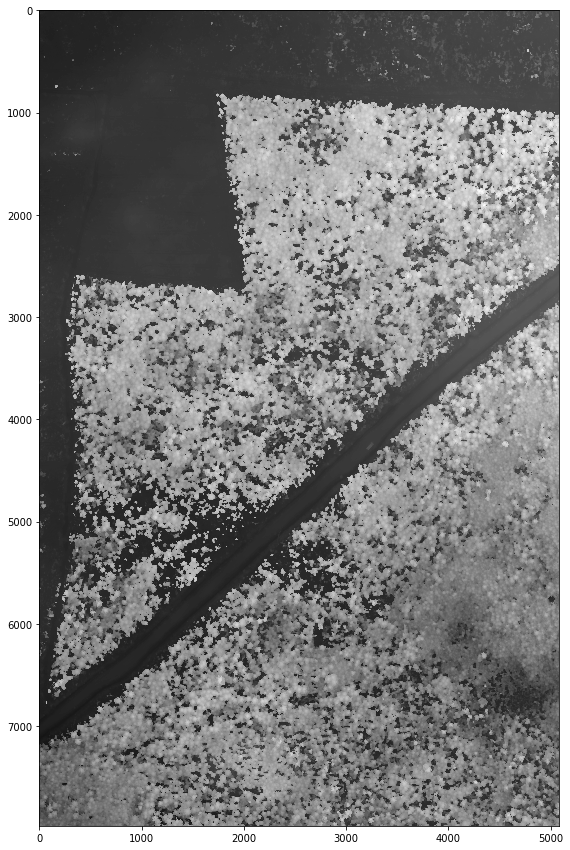

In [171]:
print(img_DEM.shape)
plott1(img_DEM)

In [172]:
range_tuple = (2000, 3000, 1000, 2000)

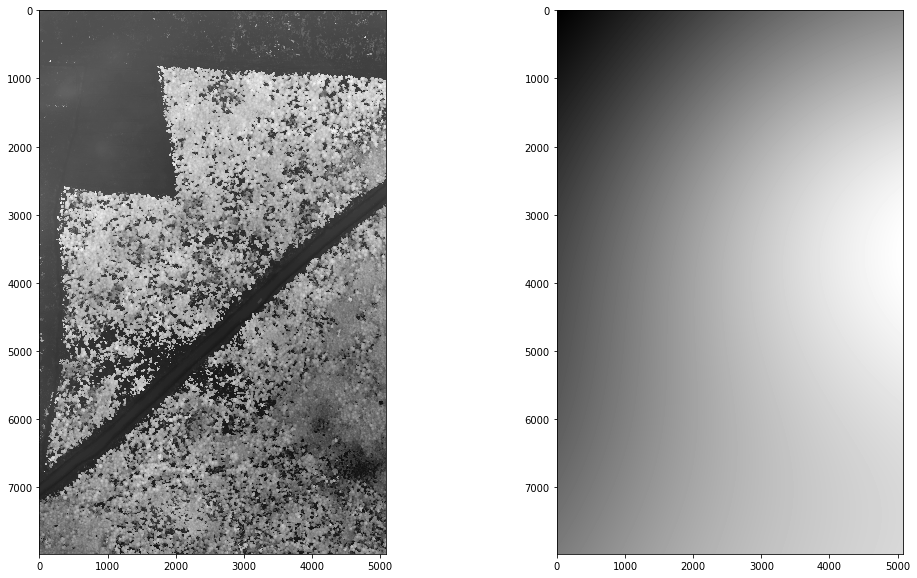

In [198]:
img_gaussian = gaussian(img_DEM, 2000)
img_flat = (img_DEM - img_gaussian)
img_flat = (img_flat - img_flat.min()) / (img_flat.max() - img_flat.min())
plott2(img_flat, img_gaussian)

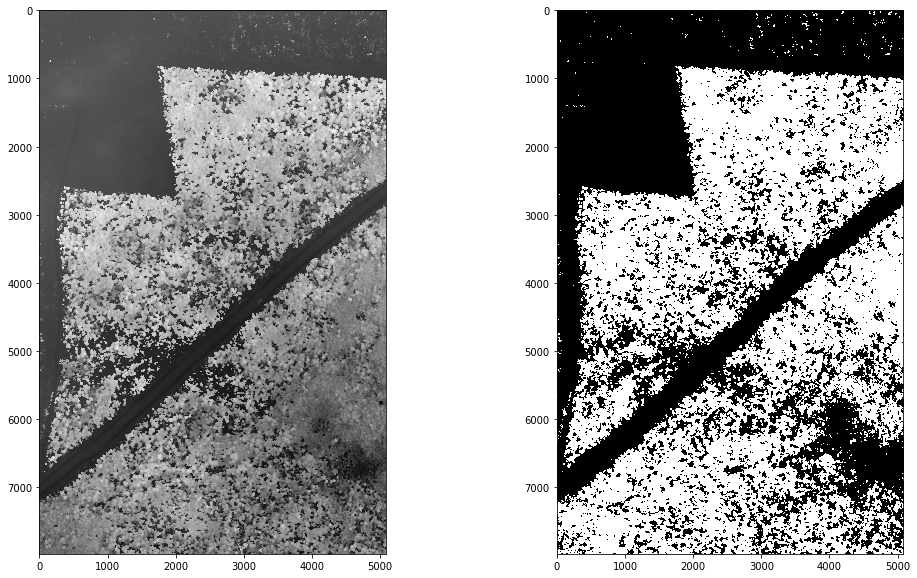

In [224]:
canopy_mask = canopy(img_flat, 0, 0, 0.40)

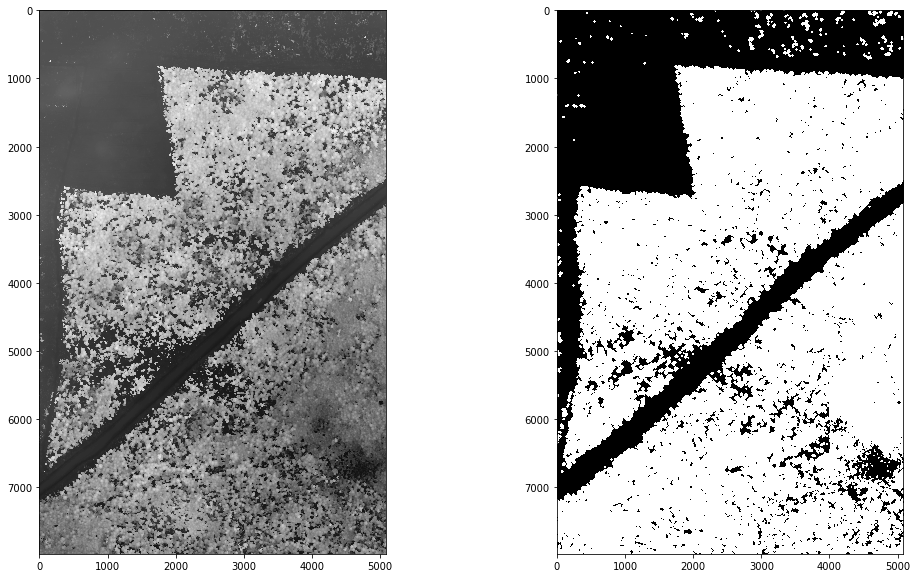

In [226]:
canopy_mask[4500:7000, 4000:] = img_flat[4500:7000, 4000:]>0.25
for i in range(3):
    canopy_mask = binary_erosion(canopy_mask)
for i in range(10):
    canopy_mask = binary_dilation(canopy_mask)

plott2(img_flat, canopy_mask)

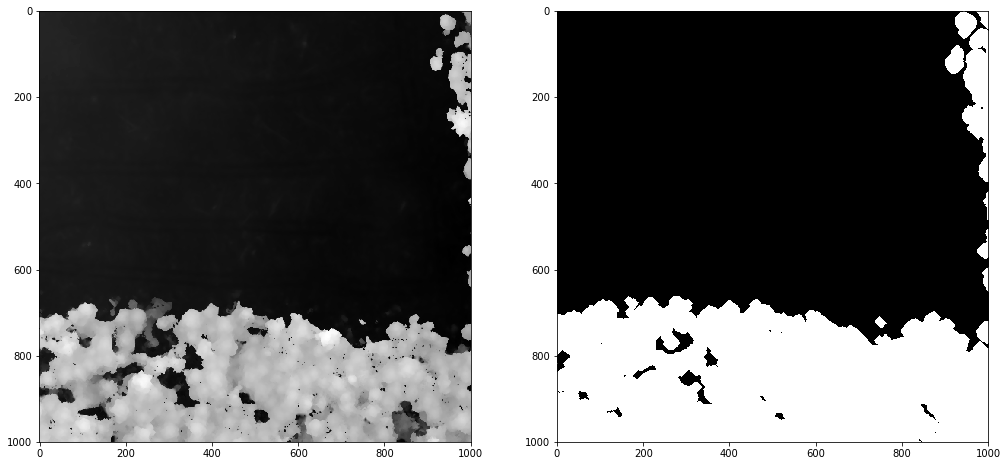

In [204]:
canopy_mask_small = canopy(img_flat, 3, 10, 0.40, range_tuple)

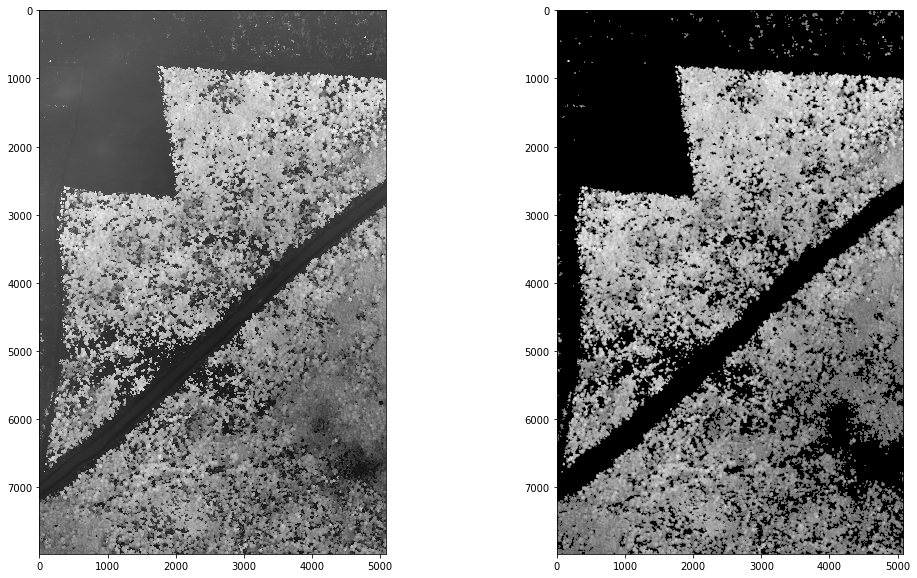

In [205]:
masked_gaussian = gaussian(img_flat, sigma=3)
masked_gaussian[canopy_mask==False] = 0

plott2(img_flat, masked_gaussian)

In [206]:
def draw_boundaries(shape, segments, n_dilation=0):
    boundaries = find_boundaries(segments)
    for i in range(n_dilation):
        boundaries = binary_dilation(boundaries)
    img_bounds = np.zeros(shape)
    img_bounds[np.where(boundaries==True)] = 1
    return img_bounds

In [207]:
local_maxima = peak_local_max(masked_gaussian, min_distance=1, exclude_border=0, indices=False)
markers, n_labels = ndi.label(local_maxima)
segments = watershed(-img_flat, markers, mask=canopy_mask)

In [208]:
bounds = draw_boundaries(img_flat.shape, segments, 1).astype(np.uint8)
bg = np.zeros(img_flat.shape).astype(np.uint8)
trees = np.zeros(img_flat.shape).astype(np.uint8)

trees[np.where((segments>0) & (bounds==False))] = 1
trees = remove_small_objects(trees > 0, min_size=35).astype(np.uint8)
trees = remove_small_holes(trees).astype(np.uint8)
bounds[np.where(trees==False)] = 1
bounds[np.where(trees==True)] = 0
bg[np.where((bounds==False) & (trees==False))] = 1
print(bg.sum() + trees.sum() + bounds.sum(), img_flat.size, bg.sum() + trees.sum() + bounds.sum() == img_flat.size)


/opt/conda/lib/python3.6/site-packages/skimage/morphology/misc.py:208: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


40515894 40515894 True


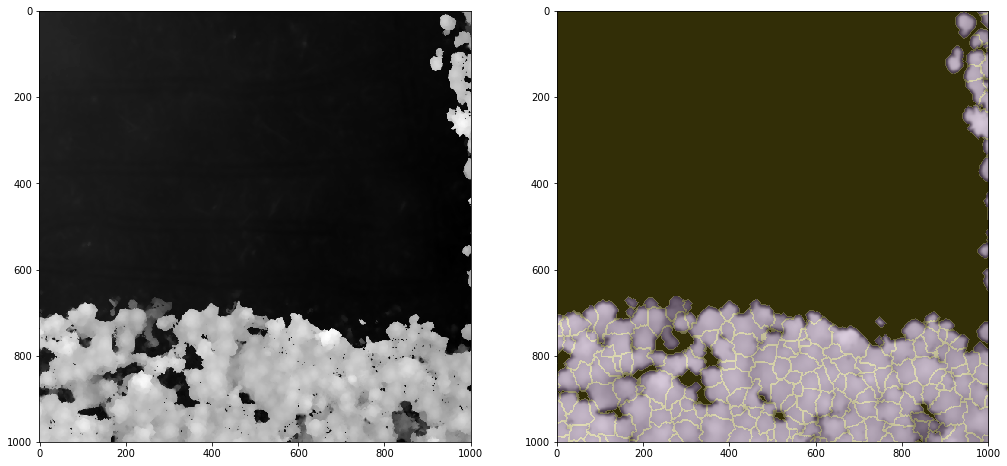

In [209]:
plott2(img_flat, masked_gaussian, range_tuple)
plt.imshow(bounds[range_tuple[0]:range_tuple[1], range_tuple[2]:range_tuple[3]], alpha=0.2)

In [4]:
ffc_gaussian = 2000
threshold = 0.40
eros = 3
dilat = 10
smoothing = 3
boundary_dilation = 4
small_obj_size1 = 4
small_obj_size2 = 10

## All in one

In [5]:
def draw_boundaries(shape, segments, n_dilation=0):
    boundaries = find_boundaries(segments)
    for i in range(n_dilation):
        boundaries = binary_dilation(boundaries)
    img_bounds = np.zeros(shape)
    img_bounds[np.where(boundaries==True)] = 1
    return img_bounds

def ITCD(OUTPUT_PATH, IMAGE_DEM, smoothing = 3):
    with rasterio.open(OUTPUT_PATH + IMAGE_DEM) as src_DEM:
        img_DEM = src_DEM.read()[0]
        profile_DEM = src_DEM.profile
        
    img_gaussian = gaussian(img_DEM, ffc_gaussian)
    img_flat = (img_DEM - img_gaussian)
    img_flat = (img_flat - img_flat.min()) / (img_flat.max() - img_flat.min())
    
    canopy_mask = img_flat > threshold
    
# #     
#     canopy_mask[3400:4000, 1450:2500] = 0
#     canopy_mask[3000:4000, 1700:2500] = 0
#     canopy_mask[:1000, :1000] = img_flat[:1000, :1000]>0.25
#     canopy_mask[4700:, :1000] = img_flat[4700:, :1000]>0.35
# # 
    canopy_mask[4500:7000, 4000:] = img_flat[4500:7000, 4000:]>0.25
# #   
    for i in range(eros):
        canopy_mask = binary_erosion(canopy_mask)
    for i in range(dilat):
        canopy_mask = binary_dilation(canopy_mask)
        
    masked_gaussian = gaussian(img_flat, sigma=smoothing)
    masked_gaussian[canopy_mask==False] = 0
    
    local_maxima = peak_local_max(masked_gaussian, min_distance=1, exclude_border=0, indices=False)
    markers, n_labels = ndi.label(local_maxima)
    print(n_labels)
    segments = watershed(-img_flat, markers, mask=canopy_mask)
    segments[np.where((segments==0) & (canopy_mask==True))] = n_labels+1
    
    profile_masks = profile_DEM
    profile_masks.update(dtype=np.uint8)
    profile_DEM.update(nodata=None)
    bounds = draw_boundaries(img_flat.shape, segments, boundary_dilation).astype(np.uint8)
    bg = np.zeros(img_flat.shape).astype(np.uint8)
    trees = np.zeros(img_flat.shape).astype(np.uint8)
    
    trees[np.where((segments>0) & (bounds==False))] = 1
    trees = remove_small_objects(trees > 0, min_size=40).astype(np.uint8)
    trees = remove_small_holes(trees).astype(np.uint8)
    
#     del line
    q, w = ndi.label(trees)
    print(w)
  
    bounds[np.where((trees==True))] = 0
    bg[np.where((bounds==False) & (trees==False))] = 1
    
    print(bg.sum() + trees.sum() + bounds.sum(), img_flat.size, bg.sum() + trees.sum() + bounds.sum() == img_flat.size)

    with rasterio.open(OUTPUT_PATH + 'mask_trees.tif', 'w', **profile_masks) as dst:
        dst.write(trees, 1)

    with rasterio.open(OUTPUT_PATH + 'mask_bounds.tif', 'w', **profile_masks) as dst:
        dst.write(bounds, 1)

    with rasterio.open(OUTPUT_PATH + 'mask_bg.tif', 'w', **profile_masks) as dst:
        dst.write(bg, 1)
    
    return profile_DEM

In [6]:
profile_DEM = ITCD(INPUT_PATH, IMAGE_PATH_DEM, smoothing)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  if sys.path[0] == '':


18116


/opt/conda/lib/python3.6/site-packages/skimage/morphology/misc.py:208: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


16378
40515894 40515894 True


## Resize masks to 0.5m resolution

In [9]:
def image_resize(input_path, img_name, orig_shape, px_size = 0.5):
    with rasterio.open(input_path + img_name + '.tif') as src:
        img = src.read()[0]
        profile = src.profile
    
    img_resize = cv.resize(img, dsize=(orig_shape[1], orig_shape[0]), interpolation=cv.INTER_NEAREST)

    profile.update(transform=rasterio.Affine(px_size, 0.0, profile['transform'][2], 0.0, -px_size, profile['transform'][5]), 
               width = img_resize.shape[1], height = img_resize.shape[0])
    return img_resize, profile

def image_save(output_path, img, img_name, profile):
    with rasterio.open(output_path + img_name + '.tif', 'w', **profile) as dst:
        dst.write(img, 1)

In [10]:
with rasterio.open(OUTPUT_PATH_RESIZE_05 + 'BLU_resize.tif') as src:
    img = src.read()[0]
    profile = src.profile
img.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


(1602, 1021)

In [11]:
mask_trees_resize, profile_resize = image_resize(INPUT_PATH, 'mask_trees', img.shape, 0.5)
mask_bg_resize, _ = image_resize(INPUT_PATH, 'mask_bg', img.shape, 0.5)
mask_bounds_resize, _ = image_resize(INPUT_PATH, 'mask_bounds', img.shape, 0.5)

mask_trees_resize = remove_small_objects(mask_trees_resize > 0, min_size=small_obj_size1).astype(np.uint8)
mask_bounds_resize[np.where((mask_trees_resize == 0) & (mask_bg_resize == 0))] = 1
# mask_bounds_resize = np.array((mask_trees_resize == False) & (mask_bg_resize == False)).astype(np.uint8)
# kernel = np.ones((2,2),np.uint8)
# mask_bounds_resize = cv.dilate(mask_bounds_resize, kernel, iterations=1)
# mask_trees_resize[mask_bounds_resize == 1] = 0
# mask_bg_resize[mask_bounds_resize == 1] = 0

image_save(OUTPUT_PATH_RESIZE_05, mask_trees_resize, 'mask_trees_resize', profile_resize)
image_save(OUTPUT_PATH_RESIZE_05, mask_bg_resize, 'mask_bg_resize', profile_resize)
image_save(OUTPUT_PATH_RESIZE_05, mask_bounds_resize, 'mask_bounds_resize', profile_resize)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  after removing the cwd from sys.path.


In [12]:
print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum(), img.size, mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum() == img.size)
q, w = ndi.label(mask_trees_resize)
print(w)

1635642 1635642 True
15534


## Resize masks to 0.3m resolution

In [13]:
with rasterio.open(OUTPUT_PATH_RESIZE_03 + 'BLU_resize.tif') as src:
    img = src.read()[0]
    profile = src.profile
profile

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1646, 'height': 2583, 'count': 1, 'crs': CRS({'init': 'epsg:32648'}), 'transform': Affine(0.31, 0.0, 322480.9922572111,
       0.0, -0.31, 6454893.724959487), 'tiled': False, 'interleave': 'band'}

In [14]:
img.shape

(2583, 1646)

In [15]:
mask_trees_resize, profile_resize = image_resize(INPUT_PATH, 'mask_trees', img.shape, 0.31)
mask_bg_resize, _ = image_resize(INPUT_PATH, 'mask_bg', img.shape, 0.31)
mask_bounds_resize, _ = image_resize(INPUT_PATH, 'mask_bounds', img.shape, 0.31)

mask_trees_resize = remove_small_objects(mask_trees_resize > 0, min_size=small_obj_size2).astype(np.uint8)
mask_bounds_resize[np.where((mask_trees_resize == 0) & (mask_bg_resize == 0))] = 1
# mask_bounds_resize = np.array((mask_trees_resize == False) & (mask_bg_resize == False)).astype(np.uint8)
# kernel = np.ones((2,2),np.uint8)
# mask_bounds_resize = cv.dilate(mask_bounds_resize, kernel, iterations=1)
# mask_trees_resize[mask_bounds_resize == 1] = 0
# mask_bg_resize[mask_bounds_resize == 1] = 0

image_save(OUTPUT_PATH_RESIZE_03, mask_trees_resize, 'mask_trees_resize', profile_resize)
image_save(OUTPUT_PATH_RESIZE_03, mask_bg_resize, 'mask_bg_resize', profile_resize)
image_save(OUTPUT_PATH_RESIZE_03, mask_bounds_resize, 'mask_bounds_resize', profile_resize)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  after removing the cwd from sys.path.


In [16]:
print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum(), img.size, mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum() == img.size)
q, w = ndi.label(mask_trees_resize)
print(w)

4251618 4251618 True
15487
